Successfully loaded data from /content/googleplaystore_user_reviews.csv

Initial DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64295 entries, 0 to 64294
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   App                     64295 non-null  object 
 1   Translated_Review       37427 non-null  object 
 2   Sentiment               37432 non-null  object 
 3   Sentiment_Polarity      37432 non-null  float64
 4   Sentiment_Subjectivity  37432 non-null  float64
dtypes: float64(2), object(3)
memory usage: 2.5+ MB

First 5 rows:
                     App                                  Translated_Review  \
0  10 Best Foods for You  I like eat delicious food. That's I'm cooking ...   
1  10 Best Foods for You    This help eating healthy exercise regular basis   
2  10 Best Foods for You                                                NaN   
3  10 Best Foods for You         Works gr

<ipython-input-1-4af949e2c52c>:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='VADER_Sentiment', data=df, palette='viridis')


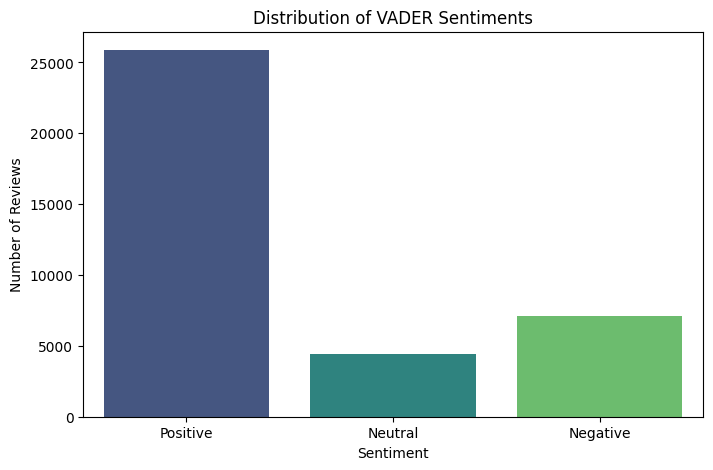


Top 5 Most Positive Reviews:
['I like eat delicious food. That\'s I\'m cooking food myself, case "10 Best Foods" helps lot, also "Best Before (Shelf Life)"', 'This help eating healthy exercise regular basis', 'Works great especially going grocery store', 'Best idea us', 'Best way']

Top 5 Most Negative Reviews:
['Waste time It needs internet time n ask calls information', 'Weight loss Not bad', 'Faltu plz waste ur time', "Crap Doesn't work", "Boring. I thought actually just texts that's it. Too poor old texts...."]

Top 5 Most Neutral Reviews:
['Looking forward app,', 'On test....', 'No recipe book Unable recipe book.', 'Very informative', 'Luv']

Analyzing Sentiment for Top 5 Apps by Review Count: ['Bowmasters', 'Helix Jump', 'Angry Birds Classic', 'Calorie Counter - MyFitnessPal', 'Duolingo: Learn Languages Free']

Sentiment Distribution for 'Bowmasters':
VADER_Sentiment
Positive    216
Negative     87
Neutral       9
Name: count, dtype: int64

Sentiment Distribution for 'Helix Jump

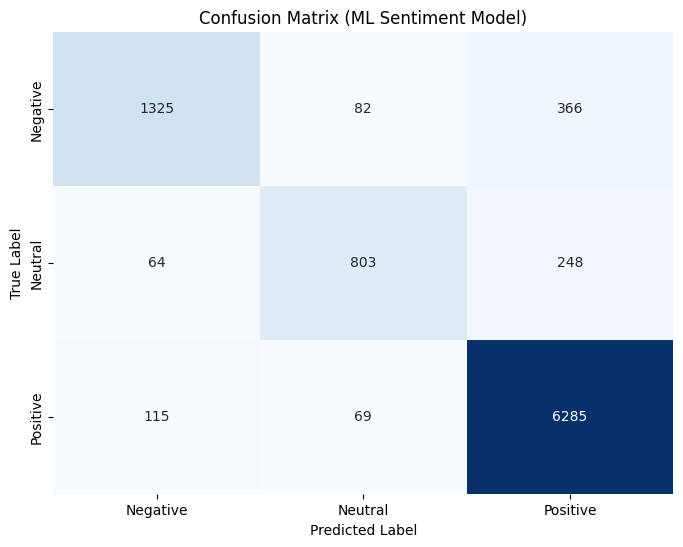


--- Insights from ML Model ---

Top 10 words most associated with Positive sentiment (based on ML model):
['love', 'great', 'good', 'best', 'easy', 'like', 'nice', 'fun', 'awesome', 'please']

Top 10 words most associated with Negative sentiment (based on ML model):
['bad', 'worst', 'hate', 'useless', 'horrible', 'terrible', 'stupid', 'problem', 'error', 'annoying']

--- Analysis Complete ---


In [1]:
# --- Install required libraries ---
!pip install pandas nltk scikit-learn --quiet

# --- IMPORTS ---
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Download NLTK resources (if not already downloaded)
nltk.download('stopwords', quiet=True)
nltk.download('vader_lexicon', quiet=True) # VADER lexicon for sentiment analysis

# --- LOAD DATA ---
file_path = "/content/googleplaystore_user_reviews.csv"
try:
    df = pd.read_csv(file_path)
    print(f"Successfully loaded data from {file_path}")
    print("\nInitial DataFrame Info:")
    df.info()
    print("\nFirst 5 rows:")
    print(df.head())
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
    exit() # Exit if data loading fails
except Exception as e:
    print(f"An error occurred while loading the data: {e}")
    exit() # Exit on other loading errors

# --- DATA PREPROCESSING ---

# Handle Missing Values
# For sentiment analysis, the 'Translated_Review' column is crucial.
# We'll drop rows where 'Translated_Review' is missing.
initial_rows = len(df)
df.dropna(subset=['Translated_Review'], inplace=True)
rows_after_dropna = len(df)
print(f"\nDropped {initial_rows - rows_after_dropna} rows with missing 'Translated_Review'.")

# Basic Text Cleaning Function
def clean_text(text):
    if isinstance(text, str): # Ensure the input is a string
        text = text.lower() # Convert to lowercase
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # Remove URLs
        text = re.sub(r'\@\w+|\#', '', text) # Remove mentions and hashtags
        text = re.sub(r'[^a-z\s]', '', text) # Remove non-alphabetic characters and keep spaces
        text = text.strip() # Remove leading/trailing whitespace
        return text
    return "" # Return empty string for non-string inputs

df['Cleaned_Review'] = df['Translated_Review'].apply(clean_text)

# Remove Stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    if isinstance(text, str): # Ensure the input is a string
        return ' '.join([word for word in text.split() if word not in stop_words])
    return ""

df['Cleaned_Review'] = df['Cleaned_Review'].apply(remove_stopwords)

print("\nDataFrame after cleaning and removing stopwords:")
print(df[['Translated_Review', 'Cleaned_Review']].head())

# --- SENTIMENT ANALYSIS (Rule-Based with VADER) ---

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to get VADER sentiment score
def get_vader_sentiment(text):
    if isinstance(text, str) and text.strip(): # Ensure text is non-empty string
        scores = analyzer.polarity_scores(text)
        # Classify based on compound score: pos >= 0.05, neg <= -0.05, neu otherwise
        if scores['compound'] >= 0.05:
            return 'Positive'
        elif scores['compound'] <= -0.05:
            return 'Negative'
        else:
            return 'Neutral'
    return 'Neutral' # Default to Neutral for empty or non-string input

df['VADER_Sentiment'] = df['Cleaned_Review'].apply(get_vader_sentiment)

print("\nDataFrame with VADER Sentiment:")
print(df[['Translated_Review', 'Cleaned_Review', 'VADER_Sentiment']].head())

# --- Sentiment Distribution ---
print("\nVADER Sentiment Distribution:")
print(df['VADER_Sentiment'].value_counts())

plt.figure(figsize=(8, 5))
sns.countplot(x='VADER_Sentiment', data=df, palette='viridis')
plt.title('Distribution of VADER Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()


# --- INSIGHTS from VADER ---

# Find top reviews for each sentiment
print("\nTop 5 Most Positive Reviews:")
print(df[df['VADER_Sentiment'] == 'Positive']['Translated_Review'].head().tolist())

print("\nTop 5 Most Negative Reviews:")
print(df[df['VADER_Sentiment'] == 'Negative']['Translated_Review'].head().tolist())

print("\nTop 5 Most Neutral Reviews:")
print(df[df['VADER_Sentiment'] == 'Neutral']['Translated_Review'].head().tolist())


# Analyze sentiment by App (example for a few apps)
# Select a few apps with a reasonable number of reviews
top_apps = df['App'].value_counts().nlargest(5).index.tolist()
print(f"\nAnalyzing Sentiment for Top 5 Apps by Review Count: {top_apps}")

for app in top_apps:
    app_df = df[df['App'] == app]
    if not app_df.empty:
        print(f"\nSentiment Distribution for '{app}':")
        sentiment_counts = app_df['VADER_Sentiment'].value_counts()
        print(sentiment_counts)
        # Optional: Plot for individual apps
        # plt.figure(figsize=(6, 4))
        # sns.countplot(x='VADER_Sentiment', data=app_df, palette='viridis')
        # plt.title(f'Sentiment Distribution for {app}')
        # plt.xlabel('Sentiment')
        # plt.ylabel('Number of Reviews')
        # plt.show()


# --- SENTIMENT ANALYSIS (Machine Learning Approach - Optional but good for comparison) ---
# This section demonstrates a simple ML model for sentiment classification.
# Note: VADER is rule-based and often a good baseline. ML models require labeled data.
# For this dataset, we don't have pre-labeled sentiment, so we'll use VADER's output
# as a proxy label to demonstrate the ML workflow. In a real scenario, you'd need
# a dataset with human-labeled sentiment.

print("\n--- Machine Learning Sentiment Classification (using VADER labels) ---")

# Prepare data for ML
# Use 'Cleaned_Review' as features (X) and 'VADER_Sentiment' as target (y)
# Map sentiments to numerical labels
sentiment_mapping = {'Positive': 2, 'Neutral': 1, 'Negative': 0}
df['Sentiment_Label'] = df['VADER_Sentiment'].map(sentiment_mapping)

# Filter out rows where sentiment mapping failed (shouldn't happen with VADER output)
df_ml = df.dropna(subset=['Sentiment_Label']).copy()
df_ml['Sentiment_Label'] = df_ml['Sentiment_Label'].astype(int) # Ensure integer type

X = df_ml['Cleaned_Review']
y = df_ml['Sentiment_Label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(f"\nTraining data size: {len(X_train)}")
print(f"Testing data size: {len(X_test)}")

# Feature Extraction using TF-IDF
# Convert text data into numerical feature vectors
tfidf_vectorizer = TfidfVectorizer(max_features=5000) # Limit features to reduce complexity

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"\nShape of TF-IDF training data: {X_train_tfidf.shape}")
print(f"Shape of TF-IDF testing data: {X_test_tfidf.shape}")


# Build and Train a Classification Model (Logistic Regression)
# Logistic Regression is a simple yet effective model for text classification
model = LogisticRegression(max_iter=1000) # Increase max_iter for convergence

print("\nTraining the Logistic Regression model...")
model.fit(X_train_tfidf, y_train)
print("Model training complete.")

# Evaluate the Model
y_pred_ml = model.predict(X_test_tfidf)

print("\n--- ML Model Evaluation ---")

accuracy_ml = accuracy_score(y_test, y_pred_ml)
print(f"Accuracy: {accuracy_ml:.4f}")

print("\nClassification Report (ML Model):")
# Use target_names for better readability of the report
target_names = ['Negative', 'Neutral', 'Positive']
print(classification_report(y_test, y_pred_ml, target_names=target_names))

# Confusion Matrix for ML model
conf_matrix_ml = confusion_matrix(y_test, y_pred_ml)
print("\nConfusion Matrix (ML Model):")
print(conf_matrix_ml)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_ml, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (ML Sentiment Model)')
plt.show()

# --- Insights from ML Model ---
# Note: Insights here are based on how well the ML model replicates VADER's output.
# Feature importance from Logistic Regression can give some insights into which words
# are most associated with different sentiments, based on the TF-IDF features.

print("\n--- Insights from ML Model ---")

# Get feature names (words) from the TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get coefficients from the Logistic Regression model
# Coefficients indicate the importance and direction of features for each class.
# For multi-class (OvR or multinomial), model.coef_ has shape (n_classes, n_features)
coefficients = model.coef_

print("\nTop 10 words most associated with Positive sentiment (based on ML model):")
# For positive sentiment (class 2)
positive_coeffs = coefficients[2]
top_positive_indices = positive_coeffs.argsort()[-10:][::-1] # Get indices of top 10 positive coefficients
top_positive_words = [feature_names[i] for i in top_positive_indices]
print(top_positive_words)

print("\nTop 10 words most associated with Negative sentiment (based on ML model):")
# For negative sentiment (class 0)
negative_coeffs = coefficients[0]
top_negative_indices = negative_coeffs.argsort()[-10:][::-1] # Get indices of top 10 negative coefficients
top_negative_words = [feature_names[i] for i in top_negative_indices]
print(top_negative_words)


# --- Further Analysis Ideas ---
# - Compare VADER and ML model outputs for discrepancies.
# - Analyze sentiment trends over time (if timestamp data was available).
# - Perform aspect-based sentiment analysis (identifying sentiment towards specific features like "camera", "battery").
# - Use more advanced NLP models (e.g., BERT, transformers) if computational resources allow.

print("\n--- Analysis Complete ---")